# Feature Sieve for Behavioral Cloning

## Atari Game: Space Invaders(D4RL)

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gym
import d4rl_atari
import sys
import os
import matplotlib.pyplot as plt

ImportError: d4rl-atari is not installed.
$ d3rlpy install d4rl_atari

In [26]:
IMAGE_DIR = "/scratch/storage0/be20b032/Behavioural Cloning/atari_v1/screens/spaceinvaders/"
TRAJ_DIR = "/scratch/storage0/be20b032/Behavioural Cloning/atari_v1/trajectories/spaceinvaders/"

# Creating list of all trajectories
trajectories = []
returns = []

for filename in os.listdir(TRAJ_DIR):
    filepath = os.path.join(TRAJ_DIR, filename)
    FOLDER_PATH = IMAGE_DIR + filename.split(".")[0] + "/"
    
    trajectory = {}
    trajectory['frame_dir'] = []
    trajectory["reward"] = []
    trajectory['score'] = []
    trajectory["terminal"] = []
    trajectory["action"] = []

    with open(filepath) as f:
        lines = f.readlines()
        
        for line in lines[2:]:
            arr = line[:-1]
            arr = arr.split(",")
            arr = [i.strip() for i in arr]

            trajectory['frame_dir'].append(FOLDER_PATH + arr[0] + ".png")
            trajectory['reward'].append(int(arr[1]))
            trajectory['score'].append(int(arr[2]))
            trajectory['terminal'].append(arr[3])
            trajectory['action'].append(int(arr[4]))

    trajectory = pd.DataFrame(trajectory)
    returns.append(trajectory.reward.sum())
    trajectories.append(trajectory)

In [27]:
#Testing out the trajectory
returns = np.array(returns)
trajectories[0].head()

,frame_dir,reward,score,terminal,action
0,/scratch/storage0/be20b032/Behavioural Cloning...,0,0,False,0
1,/scratch/storage0/be20b032/Behavioural Cloning...,0,0,False,0
2,/scratch/storage0/be20b032/Behavioural Cloning...,0,0,False,0
3,/scratch/storage0/be20b032/Behavioural Cloning...,0,0,False,0
4,/scratch/storage0/be20b032/Behavioural Cloning...,0,0,False,0


In [28]:
#List of returns of all trajectories
print(f"Total number of Trajectories: {len(returns)}")

def sample_trajs(percent, returns, trajectories):
    num_trajs = int(percent * len(returns))
    print(f"Sample Num Trajectories: {num_trajs}")
    
    ind = np.argpartition(returns, -num_trajs)[-num_trajs:]
    ind = ind[np.argsort(returns[ind])]

    sample_trajectories = [trajectories[i] for i in ind]
    sample_returns = [returns[i] for i in ind]
    return sample_trajectories, sample_returns

Total number of Trajectories: 423


Sample Num Trajectories: 21
173668


array([[<Axes: title={'center': 'reward'}>,
        <Axes: title={'center': 'score'}>],
       [<Axes: title={'center': 'action'}>, <Axes: >]], dtype=object)

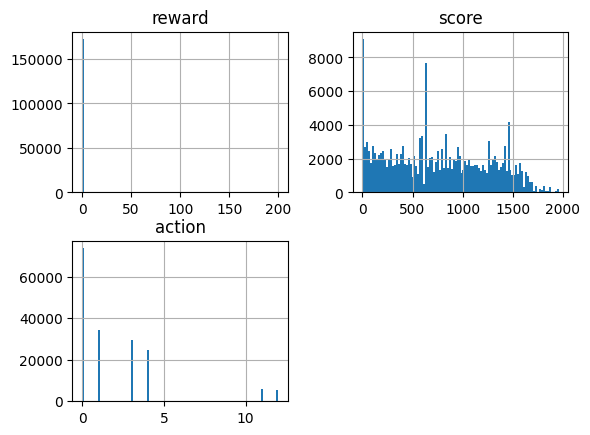

In [35]:
#Sampling out 5% trajectories
sampletrajs, sample_returns = sample_trajs(0.05, returns, trajectories)

#Combining all trajectories to make a complete dataset
trajectories_5 = pd.concat(sampletrajs)
print(len(trajectories_5))
trajectories_5.hist(bins=100)

1766078
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 16]


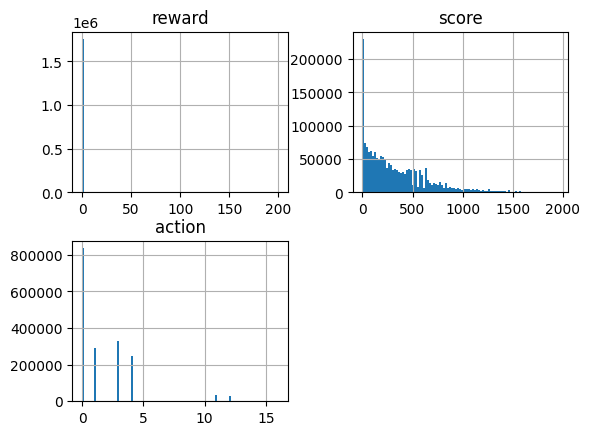

In [44]:
full_trajectories = pd.concat(trajectories)
print(len(full_trajectories))
full_trajectories.hist(bins=100)
print(pd.unique(np.sort(full_trajectories['action'])))